In [156]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

# Data acquisition
from pydataset import data

# Data modeling
from model import map_setosa_knn, train_validate_test_split

# Data
import acquire
import prepare

In [165]:
raw_data = acquire.get_telco_data()
raw_data.head()

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,payment_type_id.1,payment_type,internet_service_type_id.1,internet_service_type
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,2,65.6,593.3,No,2,One year,2,Mailed check,1,DSL
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,2,59.9,542.4,No,1,Month-to-month,2,Mailed check,1,DSL
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,1,73.9,280.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
3,3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,...,1,98.0,1237.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
4,4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,...,2,83.9,267.4,Yes,1,Month-to-month,2,Mailed check,2,Fiber optic


In [166]:
# Clean, Tidy, Prep Function
def prep_telco_data(df):
    # Drop duplicate columns
    df.drop(columns=['Unnamed: 0', \
                     'payment_type_id', \
                     'internet_service_type_id', \
                     'contract_type_id', \
                     'customer_id'], inplace=True)

    
    # Drop null values stored as whitespace    
    df['total_charges'] = df['total_charges'].str.strip()
    df = df[df.total_charges != '']
    
    # Convert to correct datatype
    df['total_charges'] = df.total_charges.astype(float)
    
    # Convert binary categorical variables to numeric
    df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
    df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
    df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
    df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})
    
    # Get dummies for non-binary categorical variables
    dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=False)
    
    #######^ change drop_first back to TRUE^ ############
    
    # Concatenate dummy dataframe to original 
    df = pd.concat([df, dummy_df], axis=1)
    
    # Create addl. features
    df['partner_w_dependents'] = np.where((df['partner_encoded'] == 1) & (df['dependents_encoded'] == 1), 1, 0)
    df['partner_no_dependents'] = np.where((df['partner_encoded'] == 1) & (df['dependents_encoded'] == 0), 1, 0)
    df['dependents_no_partner'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 1), 1, 0)
    df['no_partner_no_dependents'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 0), 1, 0)
    df['male_w_dependents'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 1) & (df['gender_encoded'] == 0), 1, 0)
    df['female_w_dependents'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 1) & (df['gender_encoded'] == 1), 1, 0)
    # encode number_relationships by utilizing information from dependents_encoded and partner_encoded
    df['number_relationships'] = df['dependents_encoded'] + df['partner_encoded']
    
   
    return df

In [167]:
# Train, Validate, Test Split Function: for exploration
def telco_split_explore(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    # 80/20 train test split
    train, test = train_test_split(df, train_size=0.8, random_state=123, stratify=df.churn)
    # 70/30 train validate split
    train, validate = train_test_split(train, train_size=0.7, random_state=123, stratify=train.churn)
    
    return train, validate, test

In [168]:
df = prep_telco_data(raw_data)
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_partner_no_dependents,male_w_dependents,female_w_dependents,number_relationships
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,0,0,1,1,0,0,0,0,0,2
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,1,0,0,0
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,1,0,0,0,0,1,0,0,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,1,0,0,1,0,0,0,0,1
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,0,0,1,0,1,0,0,0,0,1


In [169]:
telco_split_explore(df)

(      gender  senior_citizen partner dependents  tenure phone_service  \
 5919  Female               0      No         No      58           Yes   
 1915    Male               0      No        Yes      71           Yes   
 5054  Female               0     Yes        Yes      35           Yes   
 2355    Male               0     Yes        Yes       1           Yes   
 6279    Male               1      No         No      20           Yes   
 ...      ...             ...     ...        ...     ...           ...   
 394   Female               0      No         No      24           Yes   
 3763  Female               0     Yes        Yes      10           Yes   
 3444  Female               0     Yes        Yes      22           Yes   
 1002    Male               0      No        Yes      22           Yes   
 4192    Male               0      No         No       2           Yes   
 
      multiple_lines      online_security        online_backup  \
 5919            Yes                  Yes   

In [170]:
train.shape, validate.shape, test.shape

((3937, 67), (1688, 67), (1407, 67))

In [171]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_partner_no_dependents,male_w_dependents,female_w_dependents,number_relationships
5919,Female,0,No,No,58,Yes,Yes,Yes,Yes,Yes,...,1,0,0,0,0,0,1,0,0,0
1915,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,No,...,1,0,0,0,0,1,0,1,0,1
5054,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,1,0,0,0,0,0,2
2355,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,No internet service,...,0,0,1,1,0,0,0,0,0,2
6279,Male,1,No,No,20,Yes,No,Yes,No,No,...,0,0,1,0,0,0,1,0,0,0


In [51]:
### Additional code to include in prep function later...
df.drop(columns=['phone_service', \
                 'multiple_lines', \
                 'churn', \
                 'online_security', \
                 'online_backup', \
                 'device_protection', \
                 'tech_support', \
                 'streaming_tv', \
                 'streaming_movies', \
                 'paperless_billing'], inplace=True)

df

,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,contract_type_id.1,contract_type,payment_type_id.1,...,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,male_w_dependents,female_w_dependents,number_relationships
0,Female,0,Yes,Yes,9,65.60,593.30,2,One year,2,...,0,0,0,1,1,0,0,0,0,2
1,Male,0,No,No,9,59.90,542.40,1,Month-to-month,2,...,0,0,0,1,0,0,0,0,0,0
2,Male,0,No,No,4,73.90,280.85,1,Month-to-month,1,...,0,0,1,0,0,0,0,0,0,0
3,Male,1,Yes,No,13,98.00,1237.85,1,Month-to-month,1,...,0,0,1,0,0,1,0,0,0,1
4,Female,1,Yes,No,3,83.90,267.40,1,Month-to-month,2,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,55.15,742.90,2,One year,2,...,0,0,0,1,0,0,0,0,0,0
7039,Male,0,Yes,No,22,85.10,1873.70,1,Month-to-month,1,...,0,0,1,0,0,1,0,0,0,1
7040,Male,0,No,No,2,50.30,92.75,1,Month-to-month,2,...,0,0,0,1,0,0,0,0,0,0
7041,Male,0,Yes,Yes,67,67.85,4627.65,3,Two year,2,...,0,0,0,1,1,0,0,0,0,2


**Note**: `payment_type_id`, `internet_service_type_id`, and `contract_type_id` are all duplicated by `payment_type`, `internet_service_type`, and `contract_type`. We can drop the id columns. `customer_id` may not be necessary either. We can drop it for now and if we end up needing it in the end for some reason, we can go back and change that.

In [172]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  3937 non-null   object 
 1   senior_citizen                          3937 non-null   int64  
 2   partner                                 3937 non-null   object 
 3   dependents                              3937 non-null   object 
 4   tenure                                  3937 non-null   int64  
 5   phone_service                           3937 non-null   object 
 6   multiple_lines                          3937 non-null   object 
 7   online_security                         3937 non-null   object 
 8   online_backup                           3937 non-null   object 
 9   device_protection                       3937 non-null   object 
 10  tech_support                            3937 non-null   o

**Note**: Total charges is showing as an object value instead of a float value. Before we can visualize this in our summary process, we will need to clean this. 

The `total_charges` column contains whitespace characters. Lets see what those are connected to:

It looks like customers with zero tenure have no total charges, and this is being represented by the whitespace character. Dropping these observations for now.

In [173]:
# View numeric summary statistics
train.describe()

,senior_citizen,tenure,monthly_charges,total_charges,contract_type_id.1,payment_type_id.1,internet_service_type_id.1,gender_encoded,partner_encoded,dependents_encoded,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_partner_no_dependents,male_w_dependents,female_w_dependents,number_relationships
count,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,...,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000
mean,0.161290,32.775210,64.805131,2316.775641,1.693167,2.346203,1.877826,0.498095,0.485141,0.302769,...,0.227330,0.327407,0.226314,0.250445,0.234696,0.052324,0.462535,0.031750,0.020574,0.787910
std,0.367845,24.709604,30.294804,2284.984394,0.836075,1.155924,0.740151,0.500060,0.499843,0.459514,...,0.419161,0.469327,0.418498,0.433324,0.423863,0.222708,0.498658,0.175356,0.141971,0.817415
min,0.000000,1.000000,18.250000,18.850000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,34.700000,396.100000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,30.000000,70.250000,1414.800000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,56.000000,90.300000,3893.600000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
max,1.000000,72.000000,118.650000,8594.400000,3.000000,4.000000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


New features: Most of these are garbage and have multiple issues with keeping them - think critically about whether any of these should be used (do they actually supply new information not already represented by the existing fields?) and if they need to be one-hot encoded if kept. 

In [24]:
# create some new columns
df['online_backup_bool'] = df.online_backup.map({'Yes': 1, 'No': 0, 'No internet service': 0}) 
df['online_security_bool'] = df.online_security.map({'Yes': 1, 'No': 0, 'No internet service': 0})

In [25]:
# encode number_online_services by utilizing information from online_security_encoded and online_backup_encoded
df['number_online_services'] = df['online_security_bool'] + df['online_backup_bool']

In [27]:
# encode has_internet
df['has_internet'] = df.internet_service_type.apply(lambda x: 0 if x == 'None' else 1)

## Feature Engineering

##### New columns for different family types

In [ ]:
# Create New Column for is sr citizen and has fiber
df['partner&dependents'] = np.where((df['partner_encoded'] == 1) & (df['dependents_encoded'] == 1), 1, 0)

In [ ]:
# Create new column: just partner, no dependents
df['partner_no_dependents'] = np.where((df['partner_encoded'] == 1) & (df['dependents_encoded'] == 0), 1, 0)

In [ ]:
# Create new column: just dependents, no partner
df['dependents_no_partner'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 1), 1, 0)

In [101]:
df['no_partner_no_dependents'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 0), 1, 0)

In [ ]:
# Create new column: single male with dependents
df['male_w_dependents'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 1) & (df['gender_encoded'] == 0), 1, 0)

In [ ]:
# Create new column: single female with dependents
df['female_w_dependents'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 1) & (df['gender_encoded'] == 1), 1, 0)

In [ ]:
df.head()

# Exploratory Analysis

In [67]:
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,male_w_dependents,female_w_dependents,number_relationships
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,0,0,0,1,1,0,0,0,0,2
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,0,1,0,0,0,0,0,0
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,1,0,0,0,0,0,0,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,0,1,0,0,1,0,0,0,1
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,0,0,0,1,0,1,0,0,0,1


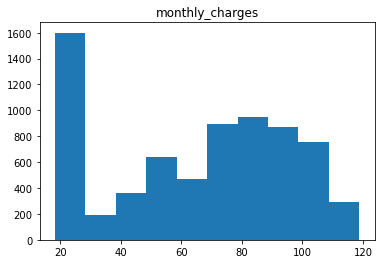

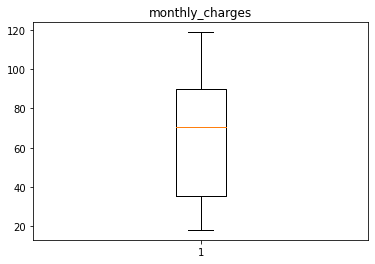

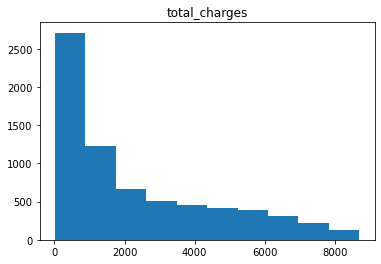

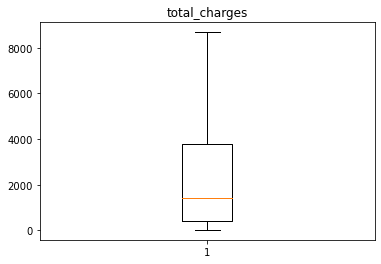

In [70]:
# Plot numeric columns
num_cols = df.columns[[df[col].dtype == 'float64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()

Text(0.5, 0, 'Churn')

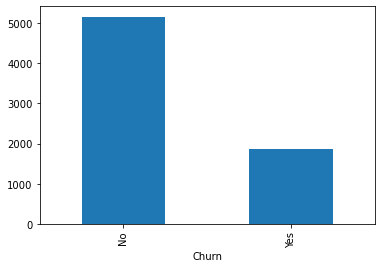

In [71]:
df.churn.value_counts().plot.bar()
plt.xlabel('Churn')

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 66 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  7032 non-null   object 
 1   senior_citizen                          7032 non-null   int64  
 2   partner                                 7032 non-null   object 
 3   dependents                              7032 non-null   object 
 4   tenure                                  7032 non-null   int64  
 5   phone_service                           7032 non-null   object 
 6   multiple_lines                          7032 non-null   object 
 7   online_security                         7032 non-null   object 
 8   online_backup                           7032 non-null   object 
 9   device_protection                       7032 non-null   object 
 10  tech_support                            7032 non-null   obje

In [65]:
for col in obj_cols:
    print(col.upper())
    print('Count:')
    print(df[col].value_counts())
    print('\n')
    print('Proportions:')
    print(df[col].value_counts(normalize=True, dropna=False))
    print('--------------------------')
    print('\n')

GENDER
Count:
Male      3549
Female    3483
Name: gender, dtype: int64


Proportions:
Male      0.504693
Female    0.495307
Name: gender, dtype: float64
--------------------------


PARTNER
Count:
No     3639
Yes    3393
Name: partner, dtype: int64


Proportions:
No     0.517491
Yes    0.482509
Name: partner, dtype: float64
--------------------------


DEPENDENTS
Count:
No     4933
Yes    2099
Name: dependents, dtype: int64


Proportions:
No     0.701507
Yes    0.298493
Name: dependents, dtype: float64
--------------------------


PHONE_SERVICE
Count:
Yes    6352
No      680
Name: phone_service, dtype: int64


Proportions:
Yes    0.903299
No     0.096701
Name: phone_service, dtype: float64
--------------------------


MULTIPLE_LINES
Count:
No                  3385
Yes                 2967
No phone service     680
Name: multiple_lines, dtype: int64


Proportions:
No                  0.481371
Yes                 0.421928
No phone service    0.096701
Name: multiple_lines, dtype: float64
-

In [58]:
pd.crosstab(raw_data.internet_service_type_id, raw_data.internet_service_type)

internet_service_type,DSL,Fiber optic,None
internet_service_type_id,,,
1,2421,0,0
2,0,3096,0
3,0,0,1526


In [59]:
pd.crosstab(raw_data.contract_type_id, raw_data.contract_type)

contract_type,Month-to-month,One year,Two year
contract_type_id,,,
1,3875,0,0
2,0,1473,0
3,0,0,1695


In [5]:
pd.crosstab(raw_data.payment_type_id, raw_data.payment_type)

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
payment_type_id,,,,
1,0,0,2365,0
2,0,0,0,1612
3,1544,0,0,0
4,0,1522,0,0


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  7032 non-null   object 
 1   senior_citizen                          7032 non-null   int64  
 2   partner                                 7032 non-null   object 
 3   dependents                              7032 non-null   object 
 4   tenure                                  7032 non-null   int64  
 5   phone_service                           7032 non-null   object 
 6   multiple_lines                          7032 non-null   object 
 7   online_security                         7032 non-null   object 
 8   online_backup                           7032 non-null   object 
 9   device_protection                       7032 non-null   object 
 10  tech_support                            7032 non-null   obje

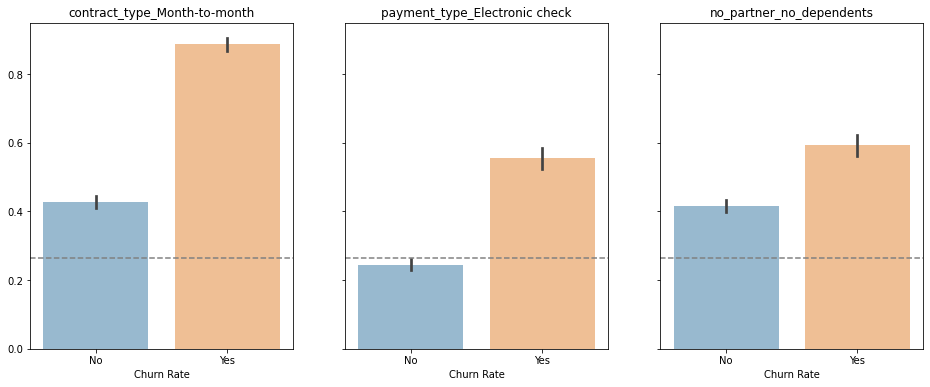

In [210]:
features = ['contract_type_Month-to-month', 'payment_type_Electronic check', 'no_partner_no_dependents']

enumerate(features)

list(enumerate(features))

churn_rate = train.churn_encoded.mean()
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot('churn', feature, data=train
                , ax=ax[i], alpha=0.5)
    ax[i].set_xlabel('Churn Rate')
    ax[i].set_ylabel('')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Exploring: Churn via p/d status

In [187]:
train.shape, validate.shape, test.shape

((3937, 67), (1688, 67), (1407, 67))

In [188]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_partner_no_dependents,male_w_dependents,female_w_dependents,number_relationships
5919,Female,0,No,No,58,Yes,Yes,Yes,Yes,Yes,...,1,0,0,0,0,0,1,0,0,0
1915,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,No,...,1,0,0,0,0,1,0,1,0,1
5054,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,1,0,0,0,0,0,2
2355,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,No internet service,...,0,0,1,1,0,0,0,0,0,2
6279,Male,1,No,No,20,Yes,No,Yes,No,No,...,0,0,1,0,0,0,1,0,0,0


Partner w/ dependents

In [174]:
pd.crosstab(train.contract_type, train.partner_w_dependents)

partner_w_dependents,0,1
contract_type,,
Month-to-month,1818,347
One year,567,248
Two year,566,391


In [175]:
pd.crosstab(train.churn, train.partner_w_dependents)

partner_w_dependents,0,1
churn,,
No,2049,842
Yes,902,144


In [185]:
# % Churn
P_w_D_Churn_Rate = 144/842
print(f'total_pop: 986')
print(f'P_w_D: {P_w_D_Churn_Rate:.2%}')

total_pop: 986
P_w_D: 17.10%


Partner, no dependents

In [177]:
pd.crosstab(train.contract_type, train.partner_no_dependents)

partner_no_dependents,0,1
contract_type,,
Month-to-month,1723,442
One year,604,211
Two year,686,271


In [178]:
pd.crosstab(train.churn, train.partner_no_dependents)

partner_no_dependents,0,1
churn,,
No,2206,685
Yes,807,239


In [186]:
P_no_D_Churn_Rate = 239/685
print(f'total_pop: 924')
print(f'P_no_D: {P_no_D_Churn_Rate:.2%}')

total_pop: 924
P_no_D: 34.89%


Dependents, no partner

In [180]:
pd.crosstab(train.contract_type, train.dependents_no_partner)

dependents_no_partner,0,1
contract_type,,
Month-to-month,2052,113
One year,767,48
Two year,912,45


In [181]:
pd.crosstab(train.churn, train.dependents_no_partner)

dependents_no_partner,0,1
churn,,
No,2727,164
Yes,1004,42


In [189]:
D_no_P_Churn_Rate = 42/164
print(f'total_pop: 206')
print(f'D_no_P: {D_no_P_Churn_Rate:.2%}')

total_pop: 206
D_no_P: 25.61%


Neither partner nor dependents (NONE)

In [183]:
pd.crosstab(train.contract_type, train.no_partner_no_dependents)

no_partner_no_dependents,0,1
contract_type,,
Month-to-month,902,1263
One year,507,308
Two year,707,250


In [184]:
pd.crosstab(train.churn, train.no_partner_no_dependents)

no_partner_no_dependents,0,1
churn,,
No,1691,1200
Yes,425,621


In [190]:
D_no_P_Churn_Rate = 621/1200
print(f'total_pop: 1821')
print(f'neither: {D_no_P_Churn_Rate:.2%}')

total_pop: 1821
neither: 51.75%


### Exploring: M2M Churn by Payment Type

In [191]:
pd.crosstab(train['contract_type_Month-to-month'], train['payment_type_Bank transfer (automatic)'])

payment_type_Bank transfer (automatic),0,1
contract_type_Month-to-month,,
0,1234,538
1,1841,324


In [192]:
pd.crosstab(train['churn'], train['payment_type_Bank transfer (automatic)'])

payment_type_Bank transfer (automatic),0,1
churn,,
No,2178,713
Yes,897,149


In [202]:
# % Churn
Bank_Tr_Churn_Rate = 149/713
print(f'total_pop: 862')
print(f'Bank_Tr_Churn_Rate: {Bank_Tr_Churn_Rate:.2%}')

total_pop: 862
Bank_Tr_Churn_Rate: 20.90%


In [194]:
pd.crosstab(train['contract_type_Month-to-month'], train['payment_type_Credit card (automatic)'])

payment_type_Credit card (automatic),0,1
contract_type_Month-to-month,,
0,1203,569
1,1839,326


In [195]:
pd.crosstab(train['churn'], train['payment_type_Credit card (automatic)'])

payment_type_Credit card (automatic),0,1
churn,,
No,2141,750
Yes,901,145


In [203]:
# % Churn
CC_Churn_Rate = 145/750
print(f'total_pop: 895')
print(f'CC_Churn_Rate: {CC_Churn_Rate:.2%}')

total_pop: 895
CC_Churn_Rate: 19.33%


In [197]:
pd.crosstab(train['contract_type_Month-to-month'], train['payment_type_Electronic check'])

payment_type_Electronic check,0,1
contract_type_Month-to-month,,
0,1491,281
1,1157,1008


In [204]:
pd.crosstab(train['churn'], train['payment_type_Electronic check'])

payment_type_Electronic check,0,1
churn,,
No,2183,708
Yes,465,581


In [205]:
# % Churn
Electronic_Check_Churn_Rate = 581/708
print(f'total_pop: 1289')
print(f'Electronic_Check_Churn_Rate: {Electronic_Check_Churn_Rate:.2%}')

total_pop: 1289
Electronic_Check_Churn_Rate: 82.06%


#### ****Electronic Check Churn Rate is VERY HIGH. Explore further!

In [200]:
pd.crosstab(train['contract_type_Month-to-month'], train['payment_type_Mailed check'])

payment_type_Mailed check,0,1
contract_type_Month-to-month,,
0,1388,384
1,1658,507


In [201]:
pd.crosstab(train['churn'], train['payment_type_Mailed check'])

payment_type_Mailed check,0,1
churn,,
No,2171,720
Yes,875,171


In [206]:
# % Churn
Mailed_Check_Churn_Rate = 171/720
print(f'total_pop: 891')
print(f'Mailed_Check_Churn_Rate: {Mailed_Check_Churn_Rate:.2%}')

total_pop: 891
Mailed_Check_Churn_Rate: 23.75%


### Exploring: (payment_type) Electronic Check - Churn

In [208]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  3937 non-null   object 
 1   senior_citizen                          3937 non-null   int64  
 2   partner                                 3937 non-null   object 
 3   dependents                              3937 non-null   object 
 4   tenure                                  3937 non-null   int64  
 5   phone_service                           3937 non-null   object 
 6   multiple_lines                          3937 non-null   object 
 7   online_security                         3937 non-null   object 
 8   online_backup                           3937 non-null   object 
 9   device_protection                       3937 non-null   object 
 10  tech_support                            3937 non-null   o

In [212]:
pd.crosstab(train['payment_type_Electronic check'], train['senior_citizen'])

senior_citizen,0,1
payment_type_Electronic check,,
0,2337,311
1,965,324


In [223]:
###### ***fiber has high churn. explore further
train.groupby('payment_type_Electronic check').internet_service_type.value_counts()

payment_type_Electronic check  internet_service_type
0                              DSL                      996
                               Fiber optic              860
                               None                     792
1                              Fiber optic              862
                               DSL                      352
                               None                      75
Name: internet_service_type, dtype: int64

In [216]:
train.groupby('payment_type_Electronic check').monthly_charges.mean()

payment_type_Electronic check
0    59.340427
1    76.031303
Name: monthly_charges, dtype: float64

In [217]:
# determines that mailed_check is not worth looking at.
# assuming that mailed_check customers are mostly senior_citizens who don't affect churn considerably
train.groupby('payment_type_Mailed check').monthly_charges.mean()

payment_type_Mailed check
0    70.861556
1    44.100449
Name: monthly_charges, dtype: float64

### Exploring: (internet_service_type) Fiber vs DSL - Churn

In [214]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  3937 non-null   object 
 1   senior_citizen                          3937 non-null   int64  
 2   partner                                 3937 non-null   object 
 3   dependents                              3937 non-null   object 
 4   tenure                                  3937 non-null   int64  
 5   phone_service                           3937 non-null   object 
 6   multiple_lines                          3937 non-null   object 
 7   online_security                         3937 non-null   object 
 8   online_backup                           3937 non-null   object 
 9   device_protection                       3937 non-null   object 
 10  tech_support                            3937 non-null   o

In [223]:
###### ***fiber has high churn. explore further
train.groupby('payment_type_Electronic check').internet_service_type.value_counts()

payment_type_Electronic check  internet_service_type
0                              DSL                      996
                               Fiber optic              860
                               None                     792
1                              Fiber optic              862
                               DSL                      352
                               None                      75
Name: internet_service_type, dtype: int64

In [216]:
train.groupby('payment_type_Electronic check').monthly_charges.mean()

payment_type_Electronic check
0    59.340427
1    76.031303
Name: monthly_charges, dtype: float64

In [217]:
# determines that mailed_check is not worth looking at.
# assuming that mailed_check customers are mostly senior_citizens who don't affect churn considerably
train.groupby('payment_type_Mailed check').monthly_charges.mean()

payment_type_Mailed check
0    70.861556
1    44.100449
Name: monthly_charges, dtype: float64

## Addl. exploration

In [74]:
df.groupby('gender_encoded').churn_encoded.value_counts()

gender_encoded  churn_encoded
0               0                2619
                1                 930
1               0                2544
                1                 939
Name: churn_encoded, dtype: int64

In [76]:
df.groupby('payment_type_id.1').churn_encoded.value_counts()

payment_type_id.1  churn_encoded
1                  0                1294
                   1                1071
2                  0                1296
                   1                 308
3                  0                1284
                   1                 258
4                  0                1289
                   1                 232
Name: churn_encoded, dtype: int64

In [ ]:
### Rubric
variables = ['contract_type_id.1', 'gender_encoded', 'payment_type_id.1']

mean = [telco_train['contract_type_id.1'].mean(), telco_train['gender_encoded'].mean(), telco_train['payment_type_id.1'].mean()]

for x in range(0,3):
    sns.barplot('churn',variables[x], data=telco_train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 66 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  7032 non-null   object 
 1   senior_citizen                          7032 non-null   int64  
 2   partner                                 7032 non-null   object 
 3   dependents                              7032 non-null   object 
 4   tenure                                  7032 non-null   int64  
 5   phone_service                           7032 non-null   object 
 6   multiple_lines                          7032 non-null   object 
 7   online_security                         7032 non-null   object 
 8   online_backup                           7032 non-null   object 
 9   device_protection                       7032 non-null   object 
 10  tech_support                            7032 non-null   obje

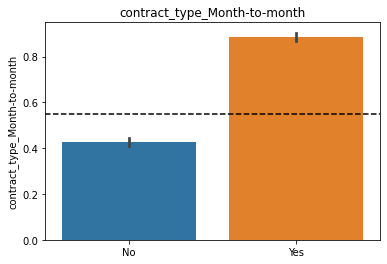

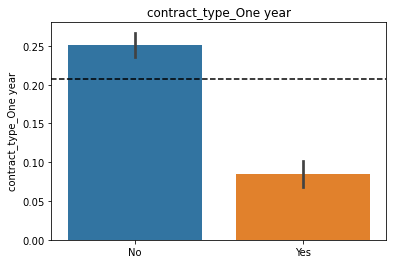

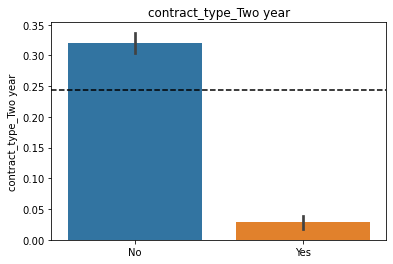

In [207]:
variables = ['contract_type_Month-to-month', 'contract_type_One year', 'contract_type_Two year']

mean = [train['contract_type_Month-to-month'].mean(), train['contract_type_One year'].mean(), train['contract_type_Two year'].mean()]

for x in range(0,3):
    sns.barplot('churn',variables[x], data=train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

In [ ]:
variables = ['contract_type_id.1', 'payment_type_id.1']

mean = [df['contract_type_id.1'].mean(), df['payment_type_id.1'].mean()]

for x in range(0,3):
    sns.barplot('churn',variables[x], data=df)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

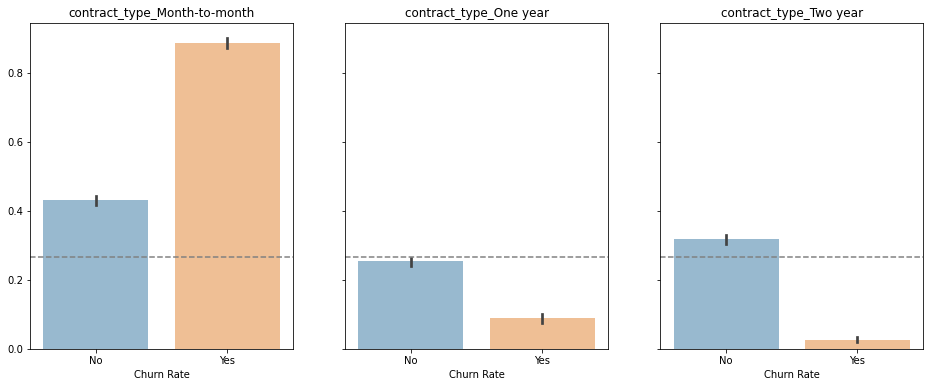

In [92]:
features = ['contract_type_Month-to-month', 'contract_type_One year', 'contract_type_Two year']

enumerate(features)

list(enumerate(features))

churn_rate = train.churn_encoded.mean()
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot('churn', feature, data=train
                , ax=ax[i], alpha=0.5)
    ax[i].set_xlabel('Churn Rate')
    ax[i].set_ylabel('')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

In [ ]:
# Train, Validate, Test Split Function: for exploration
def telco_split_explore(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    train_validate, telco_test = train_test_split(telco_prepped, test_size=.2, 
                                        random_state=123, 
                                        stratify=telco_prepped.churn)
    telco_train, telco_validate = train_test_split(train_validate, test_size=.2, 
                                   random_state=123, 
                                   stratify=train_validate.churn)
    return train, validate, test

In [ ]:
raw_data = acquire.get_telco_data()
raw_data.head()

In [ ]:
telco_prepped = prep_telco_data(raw_data)
telco_prepped

In [ ]:
telco_train, telco_validate, telco_test = telco_split_explore(telco_prepped)

In [ ]:
telco_train.shape, telco_validate.shape , telco_test.shape

In [ ]:
# Split for Modeling: X & Y dfs
def telco_split_model(df):
    '''
    This function performs split on telco data, stratifying on churn.
    Returns train, validate, and test dfs with appropriate 
    '''
    
    train, validate, test = prepare.split(df, stratify_by='churn')
    
    X_train = train.drop(columns=["churn"])
    y_train = train.churn

    X_validate = validate.drop(columns=["churn"])
    y_validate = validate.churn

    X_test = test.drop(columns=["churn"])
    y_test = test.churn

    